In [1]:
# this script loads two datasets I have downloaded, 
# the first is the supply/demand for energy in California 
# downloaded from CAISO website: http://www.caiso.com/TodaysOutlook/Pages/supply.aspx
# The second dataset is a set of ~180 million tweets collected using Twitter's 
# streaming API. The plan is to use twitter geolocation data to estimate where
# people are (and what they are doing) in order to forecast energy demand. 
# Eventually I'd like to build this into a notification app (or twitter bot) 
# which informs people of the current usage of non-Renewable energy sources. 
# The hope is that we can use social media to enact societal change.

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/media/data/caiso')
files = glob.glob('*supply*.csv')

#supply
data = []
for f in files:
    temp = pd.read_csv(f)
    temp = temp.transpose()
    temp.columns = temp.iloc[0]
    temp = temp.iloc[1:]
    temp = temp[~temp.index.str.contains('Unnamed')]
    temp = temp[~temp.index.str.contains('24:00')]
    temp.index = pd.to_datetime(temp.index,format = "%H:%M")
    year = int(f.split('-')[2].split('.')[0][:4])
    month = int(f.split('-')[2].split('.')[0][4:6])
    day = int(f.split('-')[2].split('.')[0][6:])
    temp.index = temp.index.map(lambda t: t.replace(year=year, month=month, day=day))
    data.append(temp)
    
df_supply = pd.concat(data)
df_supply = df_supply.apply(pd.to_numeric) 
df_supply = df_supply[df_supply['Natural gas']>0]
df_supply["hour"] = df_supply.index.hour
df_supply["dayofweek"] = df_supply.index.dayofweek
df_supply["year"] = df_supply.index.year
df_supply["dayofyear"] = df_supply.index.dayofyear

In [3]:
df_supply.head()

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,hour,dayofweek,year,dayofyear
2020-10-13 00:00:00,2009.0,11504.0,1435.0,7746.0,-4.0,1126.0,17.0,0.0,0,1,2020,287
2020-10-13 00:05:00,2015.0,11187.0,1375.0,8138.0,8.0,1126.0,17.0,0.0,0,1,2020,287
2020-10-13 00:10:00,2019.0,10982.0,1372.0,8377.0,10.0,1126.0,18.0,0.0,0,1,2020,287
2020-10-13 00:15:00,2008.0,10762.0,1376.0,8545.0,22.0,1126.0,17.0,0.0,0,1,2020,287
2020-10-13 00:20:00,2007.0,10481.0,1424.0,8660.0,53.0,1125.0,17.0,0.0,0,1,2020,287


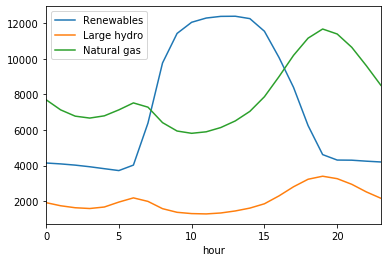

In [4]:
df_supply.groupby('hour')['Renewables','Large hydro','Natural gas'].mean().plot()

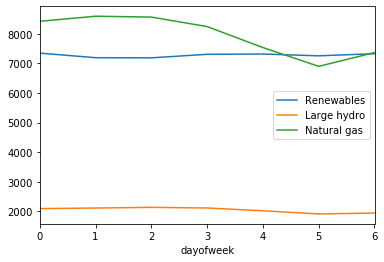

In [5]:
df_supply.groupby('dayofweek')['Renewables','Large hydro','Natural gas'].mean().plot()

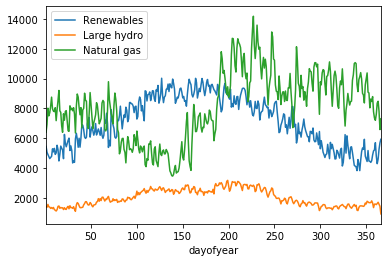

In [6]:
df_supply.groupby(['dayofyear'])['Renewables','Large hydro','Natural gas'].mean().plot()

In [7]:
# demand
files = glob.glob('*demand*.csv')
data = []
for f in files:
    temp = pd.read_csv(f)
    temp = temp.transpose()
    temp.columns = temp.iloc[0]
    temp = temp.iloc[1:]
    temp = temp[~temp.index.str.contains('Unnamed')]
    temp = temp[~temp.index.str.contains('24:00')] 
    temp = temp[~temp.index.str.contains('00:00.1|.1')]
    temp = temp.dropna()
    temp.index = pd.to_datetime(temp.index,format = "%H:%M")
    year = int(f.split('-')[2].split('.')[0][:4])
    month = int(f.split('-')[2].split('.')[0][4:6])
    day = int(f.split('-')[2].split('.')[0][6:])
    temp.index = temp.index.map(lambda t: t.replace(year=year, month=month, day=day))
    data.append(temp)
    
df_demand = pd.concat(data)
df_demand = df_demand.apply(pd.to_numeric) 
df_demand["hour"] = df_demand.index.hour
df_demand["dayofweek"] = df_demand.index.dayofweek
df_demand["year"] = df_demand.index.year
df_demand["dayofyear"] = df_demand.index.dayofyear

In [8]:
df_demand.head()

,Day-ahead forecast,Hour-ahead forecast,Demand,hour,dayofweek,year,dayofyear
2020-08-08 00:00:00,26178,26307,26091,0,5,2020,221
2020-08-08 00:05:00,24932,25930,25953,0,5,2020,221
2020-08-08 00:20:00,24932,25599,25576,0,5,2020,221
2020-08-08 00:25:00,24932,25599,25417,0,5,2020,221
2020-08-08 00:30:00,24932,25599,25297,0,5,2020,221


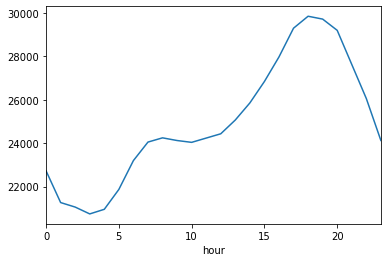

In [9]:
df_demand.groupby(['hour'])['Demand'].mean().plot()

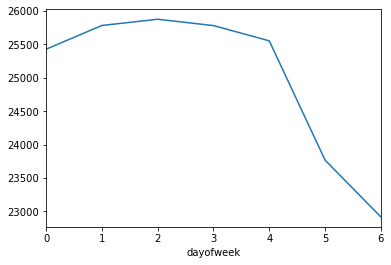

In [10]:
df_demand.groupby('dayofweek')['Demand'].mean().plot()

In [41]:
# now let's load the twitter data...
import geopandas as gpd
import datetime
from shapely.geometry import Point
os.chdir('/media/data/twitter')
ts = np.vectorize(datetime.datetime.fromtimestamp)


df = pd.read_csv('twitter_data_clean.csv',index_col = 0,nrows=15000000) # only load a clip for now, saves RAM and time
df = df[df.unix.notnull()]
dates = ts(df.unix.values/1000)
df.index = dates

/home/david/anaconda3/envs/geo_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [42]:
df = df[df['latitude'].notnull()]

print(len(df))
df.tail()

370585


,latitude,loc_source,locatin,location,longitude,sentiment,unix
2020-02-29 16:43:23.675,34.020789,place,NaN,NaN,-118.411907,-0.6310,1.583013e+12
2020-02-29 16:43:28.655,40.780709,place,NaN,NaN,-73.968542,0.7125,1.583013e+12
2020-02-29 16:43:33.654,41.691637,place,NaN,NaN,-0.927333,-0.2960,1.583013e+12
2020-02-29 16:43:35.480,51.650053,place,NaN,NaN,-0.401676,0.7176,1.583013e+12
2020-02-29 16:43:41.645,28.501679,place,NaN,NaN,-81.367773,0.7536,1.583013e+12


/home/david/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4269'})
  warn(


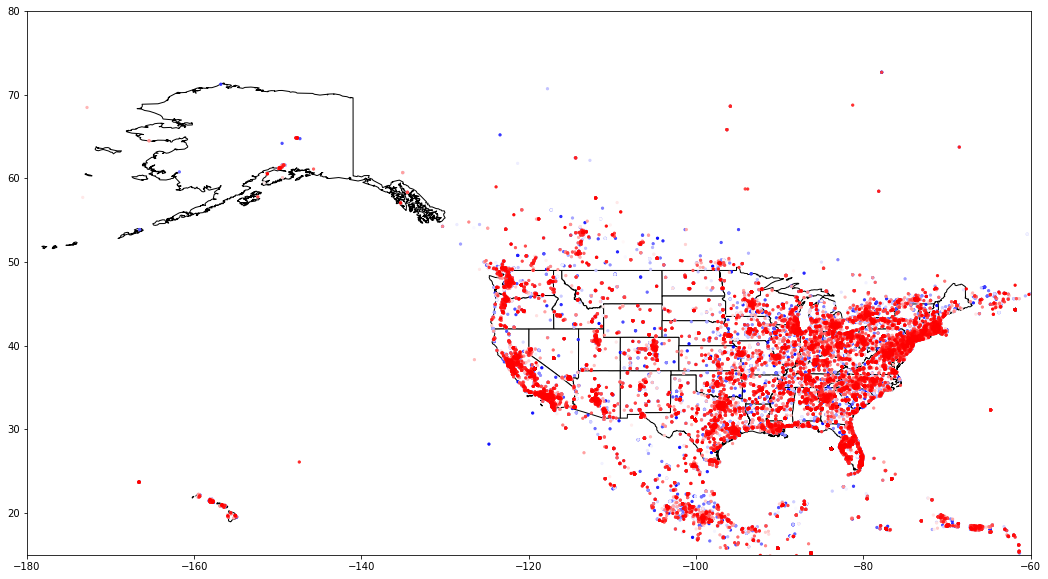

In [43]:
# Now let's take a closer look at California
usa = gpd.read_file('data/states.shp')
usa.head()

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   

# #this is a simple map that goes with geopandas
# let's look at where tweets are coming from 
gdf.plot(ax=usa.plot(figsize=(20, 10),edgecolor='k',color='w'), marker='o', cmap='bwr', markersize=5,vmin=-1,vmax=1)
plt.xlim(-180,-60)
plt.ylim(15, 80)

places = gdf
places["geometry"] = gdf.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
places = gpd.GeoDataFrame(places, geometry="geometry")
places.crs = {"init": "epsg:4326"}

# Load the states polygons
state_shapes = usa[['geometry']]
state_names = usa[['STATE_NAME']]
states = usa[['geometry', 'STATE_NAME']]
states = states.rename(columns={'STATE_NAME':'STATE_NAME'})

result2 = gpd.tools.sjoin(places, states, how="left")

Text(0.5, 1.0, "('California', 29011)")

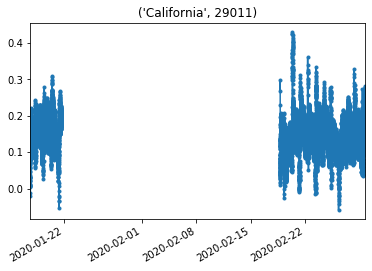

In [44]:
# and over time, in California
result2[result2['STATE_NAME']=='California']['sentiment'].rolling('2H',min_periods=10).mean().plot(marker='.')
plt.title(('California',len(result2.loc[result2['STATE_NAME']=='California'])))

In [45]:
places.head()

,latitude,loc_source,locatin,location,longitude,sentiment,unix,geometry
2020-01-17 15:12:38.526,0.0,NaN,NaN,NaN,0.0,-0.2960,1.579292e+12,POINT (0.00000 0.00000)
2020-01-17 15:12:38.547,0.0,NaN,NaN,NaN,0.0,-0.5927,1.579292e+12,POINT (0.00000 0.00000)
2020-01-17 15:12:38.688,0.0,NaN,NaN,NaN,0.0,0.4449,1.579292e+12,POINT (0.00000 0.00000)
2020-01-17 15:12:38.709,0.0,NaN,NaN,NaN,0.0,0.2263,1.579292e+12,POINT (0.00000 0.00000)
2020-01-17 15:12:38.710,0.0,NaN,NaN,NaN,0.0,0.2960,1.579292e+12,POINT (0.00000 0.00000)


(737475.2416666667, 737485.2416666667)

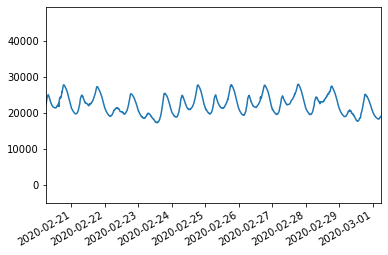

In [46]:
df_demand['Demand'].plot()
plt.xlim((datetime.datetime(2020,2,20,5,48),datetime.datetime(2020,3,1,5,48)))

(737475.2416666667, 737485.2416666667)

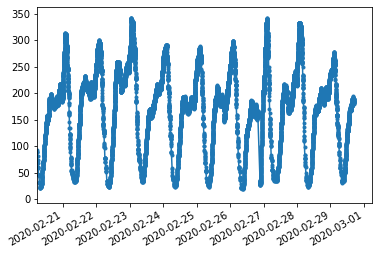

In [47]:
result2[result2['STATE_NAME']=='California']['sentiment'].rolling('2H',min_periods=10).count().plot(marker='.')
plt.xlim((datetime.datetime(2020,2,20,5,48),datetime.datetime(2020,3,1,5,48)))

(737475.2416666667, 737485.2416666667)

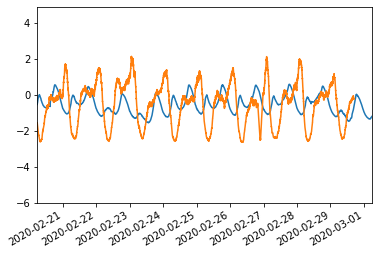

In [48]:
# From this, it looks like we may gain some predictive power on energy demands using the tweet rate (*TBD if significant when also accounting for time of day)
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
zscore(df_demand['Demand']).plot()
zscore(result2[result2['STATE_NAME']=='California']['sentiment'].rolling('2H',min_periods=10).count()).plot()
plt.xlim((datetime.datetime(2020,2,20,5,48),datetime.datetime(2020,3,1,5,48)))

In [49]:
df_histo = result2[result2['STATE_NAME']=='California']['sentiment'].rolling('2H',min_periods=10).count()

In [50]:
df_demand['tweet_count'] = df_histo.groupby(df_histo.index.floor('5min')).count().dropna()
df_supply['tweet_count'] = df_histo.groupby(df_histo.index.floor('5min')).count().dropna()

In [51]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

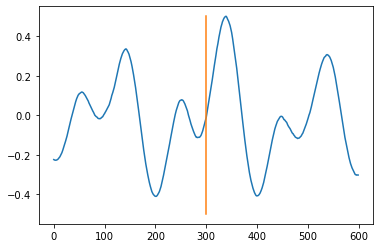

In [52]:
# cross correlation between california's tweet-rate and energy demand.
x = df_demand.dropna()['tweet_count']
y = df_demand.dropna()['Demand']
scicorr = [crosscorr(x,y, lag) for lag in range(-300,300,1)]
plt.plot(scicorr)
plt.plot([300,300],[-.5, .5])

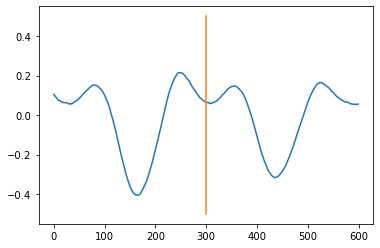

In [53]:
# cross correlation between california's tweet-rate and energy supply coming from natural gas.
x = df_supply.dropna()['tweet_count']
y = df_supply.dropna()['Natural gas']
scicorr = [crosscorr(x,y, lag) for lag in range(-300,300,1)]
plt.plot(scicorr)
plt.plot([300,300],[-.5, .5])